In [ ]:
import os
import time
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
from utils import train, plot_history
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler

In [16]:
# Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


<h1 style="color: orange;">Paths</h1>

In [17]:
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
data_dir = os.path.join(current_path, "3-Train-Val-Test-Split")
model_save_path = os.path.join(current_path, "4-Machine-Learning/Base-Model/fine_tuned_model.pth")
history_save_path = os.path.join(current_path, "4-Machine-Learning/Base-Model/fine_tune_history.json")

In [18]:
current_path

'/Users/isi.mube/Ironhack/Data-Curriculum/DSML-Master/Cosmic-Morphology'

<h1 style="color: orange;">Data Augmentation & Processing</h1>

In [19]:
# Image size expected by the ResNet50 model
input_size = 224

# Define data transformations for train, val, and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),  # Random cropping and resizing
        transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally
        transforms.RandomVerticalFlip(p=0.5),  # Flip images vertically
        transforms.RandomRotation(degrees=45),  # Rotate images randomly within ±45 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Brightness, contrast, etc.
        transforms.RandomAffine(
            degrees=15,  # Rotate within ±15 degrees
            translate=(0.1, 0.1),  # Small translations
            scale=(0.9, 1.1),  # Zoom in/out
            shear=10  # Shearing
        ),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Slight blurring
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize for ResNet50
    ]),
    'val': transforms.Compose([
        transforms.Resize(int(input_size * 1.1)),  # Resize larger to allow for cropping
        transforms.CenterCrop(input_size),  # Center crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(int(input_size * 1.1)),  # Resize larger to allow for cropping
        transforms.CenterCrop(input_size),  # Center crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

<h1 style="color: orange;">Data Loading</h1>

In [20]:
image_datasets = {
    phase: datasets.ImageFolder(
        os.path.join(data_dir, phase), 
        transform=data_transforms[phase]
    )
    for phase in ['train', 'val', 'test']
}

<h1 style="color: orange;">Data Augmentation & Processing</h1>

In [23]:
batch_size = 64  # Adjust based on available memory
dataloaders = {
    phase: DataLoader(
        image_datasets[phase],
        batch_size=batch_size,
        shuffle=(phase == 'train'),  # Shuffle only the training set
        num_workers=2  # Adjust based on your system capabilities
    )
    for phase in ['train', 'val', 'test']
}

In [24]:
dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

Classes: ['asteroid', 'comet', 'galaxy', 'nebula', 'planet', 'star']
Dataset sizes: {'train': 1800, 'val': 600, 'test': 600}


<h1 style="color: orange;">Fine-Tuning</h1>

In [27]:
model = models.resnet50(weights=None)  # Initialize an empty ResNet50 model
num_ftrs = model.fc.in_features
num_classes = len(class_names)  # Dynamically set based on your dataset
model.fc = nn.Linear(num_ftrs, num_classes)  # Update the final layer for your dataset
model.load_state_dict(torch.load("./Base-Model/best_model.pth", weights_only=True))  # Load saved weights
model = model.to(device)  # Move the model to GPU/CPU

<h2 style="color: orange;">Unfreeze</h2>

In [28]:
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

<h2 style="color: orange;">Hyperparameters</h2>

In [29]:
# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer, only for parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Scheduler to reduce learning rate periodically
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

<h2 style="color: orange;">Training</h2>

In [31]:
model, fine_tune_history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=10,  # Fewer epochs for fine-tuning
    patience=3,     # Early stopping if no improvement in validation accuracy
    min_delta=0.01  # Minimum improvement to consider
)

Epoch 1/10
----------
Train Loss: 1.3291 Acc: 0.4678
Val Loss: 1.4355 Acc: 0.4483
Epoch 2/10
----------
Train Loss: 1.2603 Acc: 0.5156
Val Loss: 1.4110 Acc: 0.4817
Epoch 3/10
----------
Train Loss: 1.1952 Acc: 0.5422
Val Loss: 1.4250 Acc: 0.4633
Epoch 4/10
----------
Train Loss: 1.1243 Acc: 0.5678
Val Loss: 1.4493 Acc: 0.4550
Epoch 5/10
----------
Train Loss: 1.0564 Acc: 0.5972
Val Loss: 1.4510 Acc: 0.4900
Early stopping triggered after 3 epochs without improvement.
Training complete


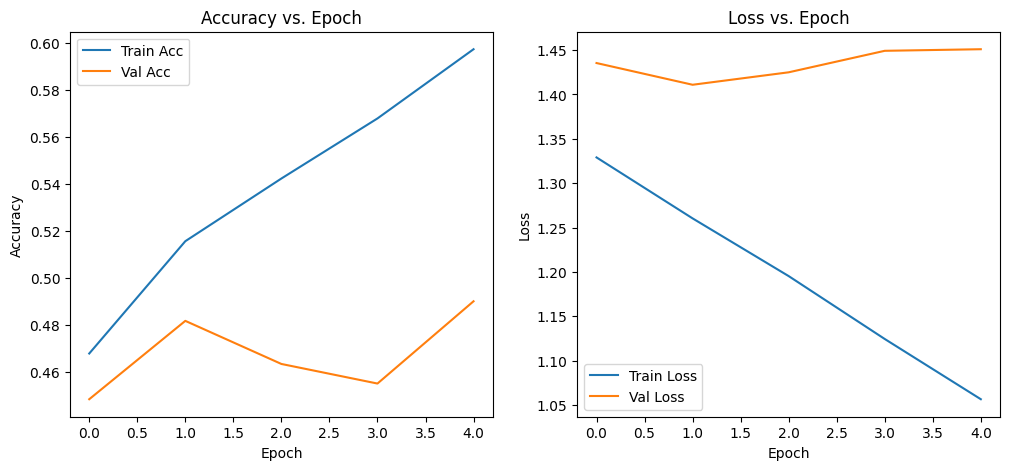

In [33]:
plot_history(fine_tune_history)

In [34]:
torch.save(model.state_dict(), "./Fine-Tuned/fine_tuned_model.pth")
print("Fine-tuned model saved!")

Fine-tuned model saved!


In [36]:
# Save training history
with open('./Base-Model/model_history.json', 'w') as f:
    json.dump(fine_tune_history, f)

print("Training history saved to './Fine-Tuned/model_history.json'")

Training history saved to './Fine-Tuned/model_history.json'
